In this notebook, an implementation for the DQN algorithm takes place (hopefully)

install notes: 

pip install pytorch

pip install matplotlib

pip install gymnasium[classic_control]

In [1]:
# imports
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np


In [2]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The Algorithm we want to implement is Deep-Q learning with Experience Replay
The pseudocode outline of the Algorithm can be seen below:


&ensp;Initialize replay memory D to capacity N<br>
&ensp;Initialize action-value function Q with random weights<br>
&ensp;**for** episode = 1, M **do** <br>
&ensp;&ensp;&ensp; Initialise sequence $s1 = {x1}$ and preprocessed sequenced $\phi_1 = \phi(s1)$<br>
&ensp;&ensp;&ensp; **for** t = 1, T **do** <br>
&ensp;&ensp;&ensp;&ensp;&ensp; With probability $\epsilon$ select a random action $a_t$<br>
&ensp;&ensp;&ensp;&ensp;&ensp; otherwise select $a_t = max_a Q^*(\phi(s_t),a;\theta)$<br>
&ensp;&ensp;&ensp;&ensp;&ensp; Execute action $a_t$ in emulator and observe reward $r_t$ and image $x_{t+1}$<br>
&ensp;&ensp;&ensp;&ensp;&ensp; Set $s_{t+1} = s_t ,a_t ,x_{t+1}$ and preprocess $\phi_{t+1} = \phi(s_{t+1})$<br>
&ensp;&ensp;&ensp;&ensp;&ensp; Store transition $(\phi_t ,a_t,r_t,\phi_{t+1})$ in D<br>
&ensp;&ensp;&ensp;&ensp;&ensp; Sample random minibatch of transitions $(\phi_j , a_j, r_j, \phi_{j+1})$ from D<br>

&ensp;&ensp;&ensp;&ensp;&ensp;$
\text{Set} \ y = \begin{cases}
r_j, & \text{for terminal} \ \phi_{j+1} \\
r_j+\gamma \ max_{a^{'}}Q(\phi_{j+1}, a';\theta), & \text{for non-terminal } \ \phi_{j+1}
\end{cases}
$

&ensp;&ensp;&ensp;&ensp;&ensp;Perform a gradient descent step on $(y_j − Q(\phi_j, a_j; \theta))²$<br>
&ensp;&ensp;&ensp;**end for**<br>
&ensp;**end for**

The gradient descent step is given by:<br>
$\nabla_{\theta_i}L_i(\theta_i) = \mathbb{E}_{s, a \sim p(\cdot);s'\sim \epsilon} \big[\big(r+\gamma \max_{a'} Q(s', a';\theta_{i-1})-Q(s,a;\theta_i)\big)\nabla_{\theta_i}(s,a;\theta_i) \big]$

---

Notes: <br>
3 processes:<br>
- Process 1: Data Aquisition to fill buffer (latest Q function with some exploration)
- Process 2: Updates Target parameters (slower than Process 1 and 3, like every 10k iterations), copies $\phi$ into $\phi'$, with $\phi'$ being the current target
- Process 3: Actuall Training, fetch data from buffer, update our Q function $\phi$


---

In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

First enviroment: pendulum
--

Action Space: Box(-2.0, 2.0, (1,), float32)

Observation Space: Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)


In [5]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
CAPACITY = 10000 # Capacity of Replay Memory Buffer
GAMMA = 0.99
EPS_START = 0.9 # Epsilon Greedy with decay rate based on steps taken for exploration
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005 # Instead of doing a hard update from the policy network to the target network, we do a soft update every iteration
LR = 1e-4


env = gym.make("Pendulum-v1")
# env = gym.make("Pendulum-v1", render_mode='human')
# Discretized Action Space
action_range = (env.action_space.low[0], env.action_space.high[0])
n_actions = 10
actions = np.linspace(action_range[0], action_range[1], n_actions)

# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(CAPACITY)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([np.digitize(env.action_space.sample(), actions)], device=device, dtype=torch.long)

episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 2:
        means = durations_t.unfold(0, 2, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(1), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

: 

$\nabla_{\theta_i}L_i(\theta_i) = \mathbb{E}_{s, a \sim p(\cdot);s'\sim \epsilon} \big[\big(r+\gamma \max_{a'} Q(s', a';\theta_{i-1})-Q(s,a;\theta_i)\big)\nabla_{\theta_i}(s,a;\theta_i) \big]$

we want to minimize: (loss_function):

$(y_j − Q(\phi_j, a_j; \theta))²$

where

$
\text{Set} \ y = \begin{cases}
r_j, & \text{for terminal} \ \phi_{j+1} \\
r_j+\gamma \ max_{a^{'}}Q(\phi_{j+1}, a';\theta), & \text{for non-terminal } \ \phi_{j+1}
\end{cases}
$




In [ ]:
def loss_function(Q_values, target_Q_values, rewards, done):
    # Calculate the target values
    if done:
        y = rewards
    else:
        y = rewards + GAMMA * torch.max(target_Q_values, dim=-1)[0] 

    # Calculate the temporal difference error
    TD_error = y - Q_values.gather(1, actions)

    # Square the TD error
    squared_TD_error = TD_error ** 2

    # Calculate the mean squared TD error
    loss = torch.mean(squared_TD_error)

    return loss


In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [ ]:
state, info = env.reset()
sampled_value = env.action_space.sample()
mapped_action = np.digitize(sampled_value, actions)
print(mapped_action, sampled_value, actions)
print(actions[mapped_action])
env.step(actions[mapped_action])

[6] [0.50413066] [-2.         -1.55555556 -1.11111111 -0.66666667 -0.22222222  0.22222222
  0.66666667  1.11111111  1.55555556  2.        ]
[0.66666667]


(array([ 0.23762211, -0.9713577 , -1.5443963 ], dtype=float32),
 -1.6589309475119358,
 False,
 False,
 {})

Complete


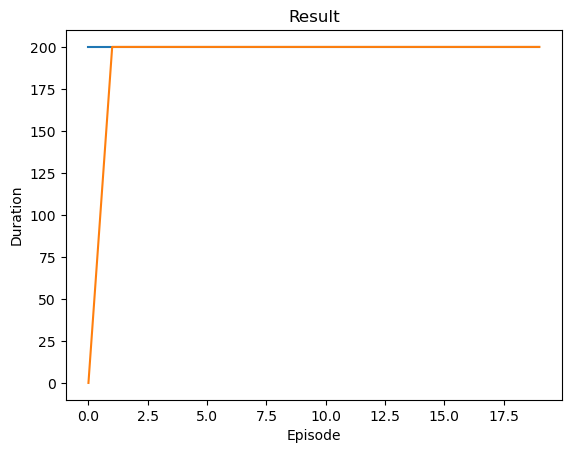

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 20

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state) # change to select_action(state)
        # print(action.item())
        observation, reward, terminated, truncated, _ = env.step([actions[action.item()]])
        env.render()
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()